# Classification of Pneumonia, Covid-19, and Normal Chest X-ray Using deep learning models

### imports

In [104]:
print("hello")

hello


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras import layers
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

C:\Users\FYP-23F\anaconda3\envs\py310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Allow GPU if have

In [3]:
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     print('here')
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Get the list of physical GPU devices available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU device
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available")


2 Physical GPUs, 2 Logical GPUs



### Defining path to data source

In [5]:
#### THIS IS FOR FYP LAB BLOCK 1 ######
#train_data_dir = r'C:\Users\Student\Documents\FA\DS\train'
#val_data_dir = r'C:\Users\Student\Documents\FA\DS\val'
#test_data_dir = r'C:\Users\Student\Documents\FA\DS\test'

#### THIS IS FOR CRAIB LAB BLOCK 5 ######
#train_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\train'
#val_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\val'
#test_data_dir = r'C:\Users\FYP-23F\Documents\FA\DS\test'


# Check the number of images in each category
# labls = ['training', 'validation', 'testing']
# directories = [train_data_dir, val_data_dir, test_data_dir]
# for i in range(3):
#     print(f"################ ALL IMAGES FOR {labls[i].upper()} ################")
#     print(f"There are {len(os.listdir(os.path.join(directories[i], 'COVID')))} images of COVID for {labls[i]}")
#     print(f"There are {len(os.listdir(os.path.join(directories[i], 'NORMAL')))} images of NORMAL for {labls[i]}")
#     print(f"There are {len(os.listdir(os.path.join(directories[i], 'PNEUMONIA')))} images of PNEUMONIA for {labls[i]}")
#     print()


#### THIS IS FOR CROSS FOLD VALIDATION ######
parent_dir = r'C:\Users\FYP-23F\Desktop\folds'
childs_dirs = os.listdir(parent_dir)
common_dirs = ['train', 'val', 'test']
labels = ['COVID', 'PNEUMONIA', 'NORMAL']
for i in range(len(childs_dirs)):
    print(f"################ FOLD_{i+1} ################")
    for j in range(len(common_dirs)):
        for k in range(len(labels)):
            print(f"{common_dirs[j]} ({labels[k]}) : {len(os.listdir(os.path.join(parent_dir, childs_dirs[i], common_dirs[j], labels[k] )))}")

################ FOLD_1 ################
train (COVID) : 812
train (PNEUMONIA) : 899
train (NORMAL) : 900
val (COVID) : 326
val (PNEUMONIA) : 361
val (NORMAL) : 361
test (COVID) : 488
test (PNEUMONIA) : 540
test (NORMAL) : 541
################ FOLD_2 ################
train (COVID) : 812
train (PNEUMONIA) : 899
train (NORMAL) : 900
val (COVID) : 326
val (PNEUMONIA) : 361
val (NORMAL) : 361
test (COVID) : 488
test (PNEUMONIA) : 540
test (NORMAL) : 541
################ FOLD_3 ################
train (COVID) : 812
train (PNEUMONIA) : 899
train (NORMAL) : 900
val (COVID) : 326
val (PNEUMONIA) : 361
val (NORMAL) : 361
test (COVID) : 488
test (PNEUMONIA) : 540
test (NORMAL) : 541
################ FOLD_4 ################
train (COVID) : 812
train (PNEUMONIA) : 899
train (NORMAL) : 900
val (COVID) : 326
val (PNEUMONIA) : 361
val (NORMAL) : 361
test (COVID) : 488
test (PNEUMONIA) : 540
test (NORMAL) : 541
################ FOLD_5 ################
train (COVID) : 812
train (PNEUMONIA) : 899
train (

### Hyperparameters or fixed parameters

In [6]:
batch_size = 32 # previously it was 32
input_shape = (256,256,3)
num_classes = 3

### Data Augmentation technique

In [7]:
def data_generator(TRAIN_DIR, VAL_DIR, TEST_DIR):
    """
    Arguments:
    TRAIN_DIR(string): directory path containing training images
    VAL_DIR(string): directory path containing validation images
    TEST_DIR(string): directory path containing testing images

    Return:
    train_generator, val_generator, test_generator
    """
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    val_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [8]:
# train_generator, val_generator, test_generator = data_generator(train_data_dir, val_data_dir, test_data_dir)

### Compute class weights for each category

In [9]:
def compute_class_weights(train_generator):
    """
    Arguments:
    train_generator(generator): Generator for training images

    Return:
    class_weight(dict): Dictionary representing the class wiegts and their proportion of images

    """
    
    tot_classes = np.unique(train_generator.classes)
    print(tot_classes)
    class_weights = compute_class_weight(
                                            class_weight = "balanced",
                                            classes = tot_classes,
                                            y = train_generator.classes                                                    
                                        )
    class_weights = dict(zip(tot_classes, class_weights))
    class_weights

### Loading base model of VGG19 without the last layers

In [10]:
def def_base_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Make all the layers non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

### Defining our own layers and pipeline with pre-trained

In [11]:
def def_model(base_model):
    """
    Arguments:
    base_model_inputs: pre-defined base model

    Return:
    model: The final model used for our system
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    classification_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.inputs, outputs=classification_layer)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    #model.summary()

    return model

### Define self model

In [12]:
def self_model():
    model = tf.keras.models.Sequential([
        layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')

    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    #print(model.summary())

    return model

### Define Callbacks for model

In [13]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Reached the accuracy of 97%, so cancelling the training")
            self.model.stop_training = True

### Train the model

In [14]:
tr_acc = []
tr_loss = []
val_acc = []
val_loss = []
test_acc = []
test_l = []
c_m = []
rep_data = []
his = []
epochs = 100

In [15]:
def train_model(self_model_tr=False):
    for i in range(len(childs_dirs)):
        model_checkpoint = ModelCheckpoint(F"vgg16_f{i+1}_model.h5", save_best_only=True,save_weights_only=False)
        model_early_stopping = EarlyStopping(patience=12, restore_best_weights=True)
        mycallback = myCallbacks()
        print(f"################ TRAINING OF FOLD_{i+1} ################")
        train_generator, val_generator, test_generator = data_generator(os.path.join(parent_dir, childs_dirs[i], 'train'),
                                                                        os.path.join(parent_dir, childs_dirs[i], 'val'), 
                                                                        os.path.join(parent_dir, childs_dirs[i], 'test')
                                                                       )
        if (self_model_tr):
            model = self_model()
        else:
            base_model = def_base_model()
            model = def_model(base_model)
        history = model.fit(train_generator, epochs = epochs, validation_data = val_generator, callbacks = [model_checkpoint, mycallback, model_early_stopping])
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        y_pred = model.predict(test_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes
        cm = confusion_matrix(y_true, y_pred_classes)
        class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices)
        train_acc = history.history['accuracy']
        validate_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        validate_loss = history.history['val_loss']
        his.append(history)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_acc.append(validate_acc)
        val_loss.append(validate_loss)
        test_acc.append(test_accuracy)
        test_l.append(test_loss)
        c_m.append(cm)
        rep_data.append(class_report)

In [16]:
train_model(self_model_tr=True)

################ TRAINING OF FOLD_1 ################
Found 2611 images belonging to 3 classes.
Found 1048 images belonging to 3 classes.
Found 1569 images belonging to 3 classes.
Epoch 1/100
82/82 [==============================] - 104s 1s/step - loss: 0.9899 - accuracy: 0.4814 - val_loss: 0.7573 - val_accuracy: 0.5821
Epoch 2/100
82/82 [==============================] - 48s 588ms/step - loss: 0.7899 - accuracy: 0.6101 - val_loss: 0.6363 - val_accuracy: 0.7328
Epoch 3/100
82/82 [==============================] - 48s 584ms/step - loss: 0.6531 - accuracy: 0.7139 - val_loss: 0.6010 - val_accuracy: 0.7366
Epoch 4/100
82/82 [==============================] - 49s 594ms/step - loss: 0.5865 - accuracy: 0.7671 - val_loss: 0.4727 - val_accuracy: 0.8101
Epoch 5/100
82/82 [==============================] - 48s 584ms/step - loss: 0.5225 - accuracy: 0.7966 - val_loss: 0.4084 - val_accuracy: 0.8378
Epoch 6/100
82/82 [==============================] - 46s 559ms/step - loss: 0.5219 - accuracy: 0.8043 -

### Plotting Confusion Matrices

In [34]:
def plot_confusion_matrices(confusion_matrices, test_acc):
    classes = ['COVID', 'NORMAL', 'PNEUMONIA']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(confusion_matrices):
            cm = confusion_matrices[i]
            im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
            ax.set_title(f'Fold {i + 1}')
            ax.set_xticks(np.arange(len(classes)))
            ax.set_yticks(np.arange(len(classes)))
            ax.set_xticklabels(classes, rotation=45)
            ax.set_yticklabels(classes)

            thresh = cm.max() / 2.
            for x, y in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                ax.text(y, x, format(cm[x, y], 'd'), horizontalalignment="center", color="white" if cm[x, y] > thresh else "black")

            ax.set_xlabel('Predicted label')
            ax.set_ylabel('True label')  

            # Add legend with testing accuracy
            # Add legend with testing accuracy
            legend_str = f'Test Acc: {round(test_acc[i], 2)}'
            legend_line = Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markersize=0, label=legend_str)
            ax.legend(handles=[legend_line], loc='upper right')
        else:
            ax.axis('off')  # If there are fewer than 6 confusion matrices, turn off the empty subplot.

    plt.tight_layout()
    plt.show()





Value of i is :  0.9464626908302307
Value of i is :  0.9324410557746887
Value of i is :  0.9241555333137512
Value of i is :  0.9579349756240845
Value of i is :  0.9394518733024597


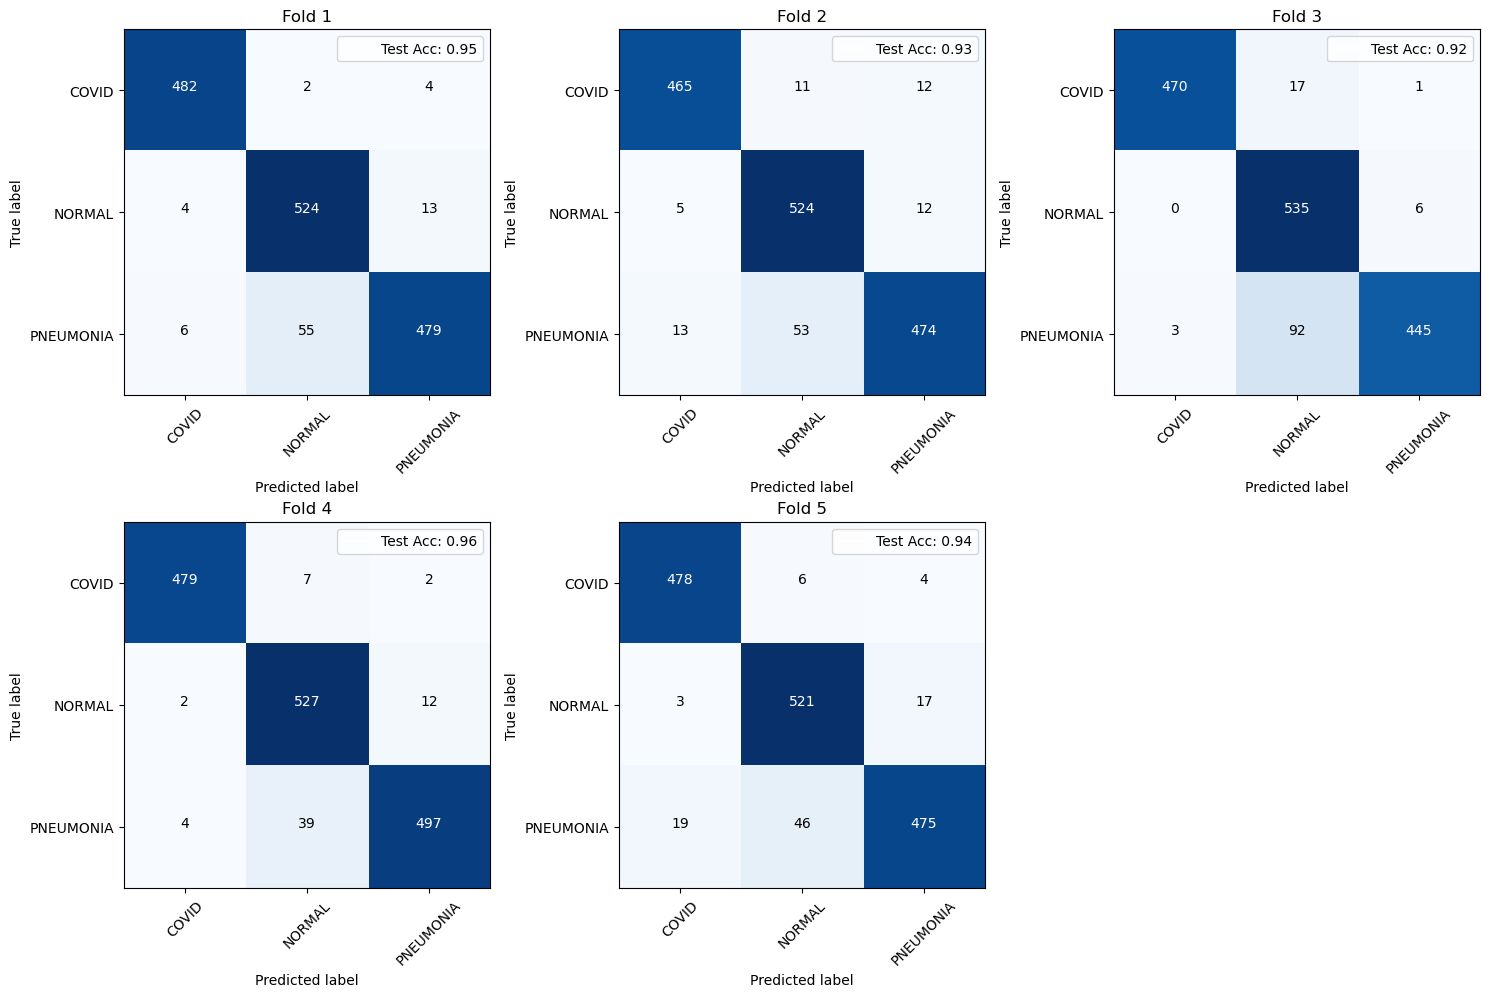

In [35]:
plot_confusion_matrices(c_m, test_acc)

### plot accuracy graphs

In [18]:
def plot_fold_data(tr_acc_list, val_acc_list, tr_loss_list, val_loss_list):
    num_folds = len(tr_acc_list)

    # Create subplots in a grid with 2 columns and len(tr_acc_list) rows
    fig, axes = plt.subplots(len(tr_acc_list), 2, figsize=(15, 5 * len(tr_acc_list)))

    for i, (acc_ax, loss_ax) in enumerate(axes):
        # Plot accuracy
        acc_ax.plot(tr_acc_list[i], color='green', label='Train')
        acc_ax.plot(val_acc_list[i], color='orange', label='Validation')
        acc_ax.set_xlabel("Epoch")
        acc_ax.set_ylabel("Accuracy")
        acc_ax.legend(loc='lower right')
        acc_ax.set_title(f'Fold {i + 1} - Accuracy')

        # Plot loss
        loss_ax.plot(tr_loss_list[i], color='red', label='Train')
        loss_ax.plot(val_loss_list[i], color='blue', label='Validation')
        loss_ax.set_xlabel("Epoch")
        loss_ax.set_ylabel("Loss")
        loss_ax.legend(loc='upper right')
        loss_ax.set_title(f'Fold {i + 1} - Loss')

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_fold_data(tr_acc_list, val_acc_list, tr_loss_list, val_loss_list)


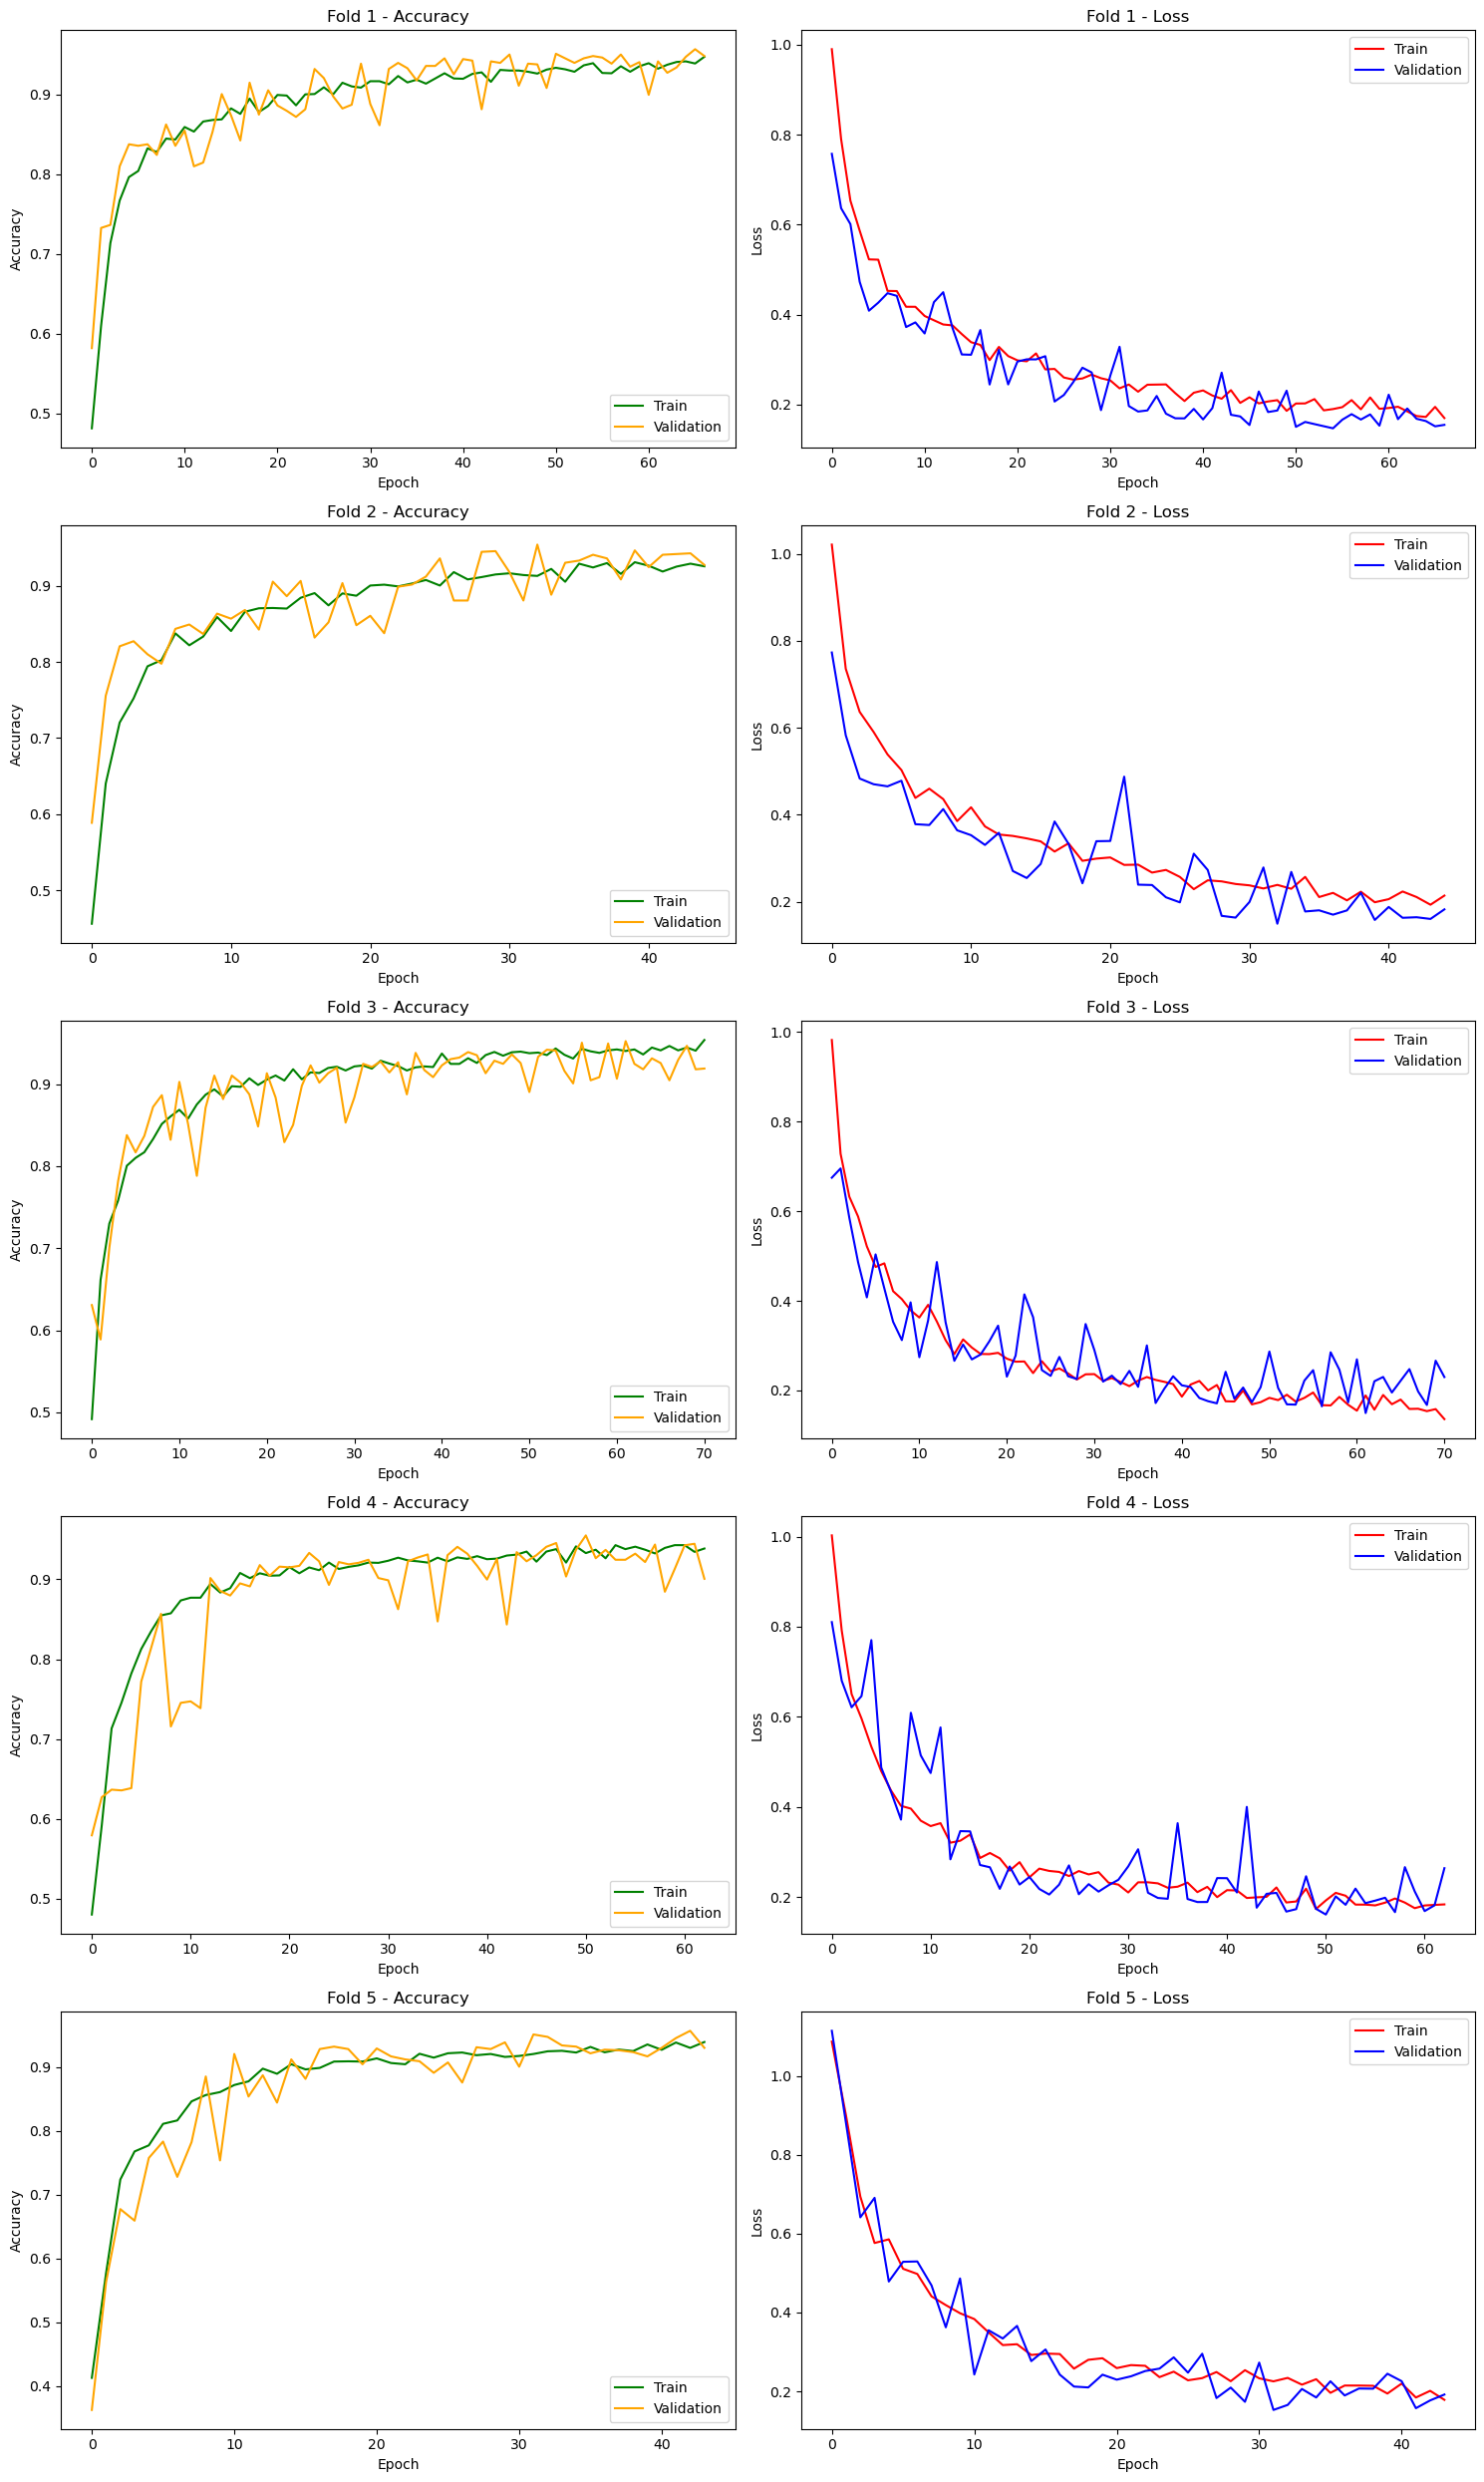

In [19]:
plot_fold_data(tr_acc, val_acc, tr_loss, val_loss) 

In [20]:
data = {
    "Folds":childs_dirs,
    "Test Acc": test_acc,
    "Test loss": test_l
}

In [22]:
pd.DataFrame(data).to_csv(r'C:\Users\FYP-23F\Documents\FA\results.csv', index=False)